In [29]:
from PIL import Image
import requests
import os
import torch
import torchvision
from transformers import CLIPProcessor, CLIPModel
from transformers import ViTForImageClassification
import warnings

# Set and print device hardware
if(torch.cuda.is_available()):
    device_hardware = torch.device('cuda')
    print(f"GPU is available")
else:
    device_hardware = torch.device('cpu')
    print(f"No GPU is configured")

GPU is available


# Hugging Face Implementation
ref: https://huggingface.co/openai/clip-vit-base-patch16

In [2]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

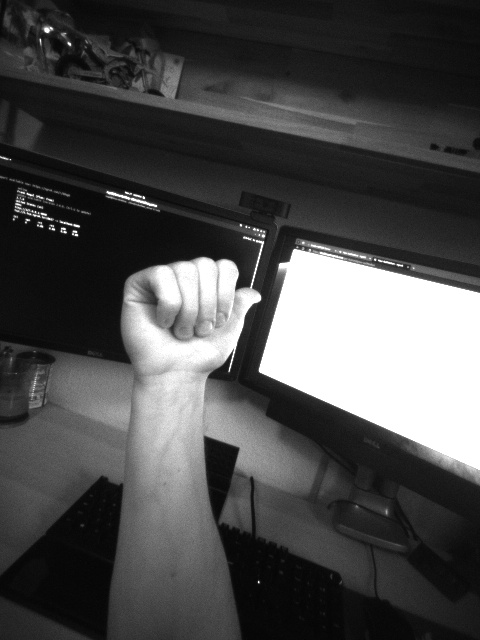

In [17]:
#url = "http://images.cocodataset.org/val2017/000000039769.jpg"
#image = Image.open(requests.get(url, stream=True).raw)
#path = "/project/my_playground/data/img/20240131_162233_d_rr_go_right/img_00199.jpg"
#path = "/project/my_playground/data/img/20240131_141501_a_ll_stop/img_00042.jpg"
#path = "/project/my_playground/data/img/20240131_155517_d_rr_hold/img_00159.jpg"
#path = "/project/my_playground/data/img/go_left_thumb/img_00065.jpg"
path = "/project/my_playground/data/img/go_right_thumb/img_00038.jpg"
image = Image.open(path)
display(image)

In [123]:
gesture_map = [
    {'pointing': ['human arm straight, directing', 12]},
    {'stop': ['right hand, closed fist held up high, gripped fingers, view of the knuckles of hand',0]},
    {'hold': ['open palm, thumb open straight pointing to right area of image, view of the knuckles of hand',0]},
    {'go left': ['right hand, closed palm, gripped fingers, thumb open straight pointing to left area of image, view of the knuckles of hand',0]},
    {'go right': ['right hand, closed palm, gripped fingers, thumb open straight pointing to right area of image, view of the wrist of hand',0]}]

# prompts = [prompt for _, prompt in gesture_map.values()]
prompts = [list(prompt.values())[0][1] for idx, prompt in enumerate(gesture_map)]
print(prompts)

print(gesture_map[0]['pointing'])

for i, ges in enumerate(gesture_map):
    for j, key in ges.keys():
        ges[key][1] = 23
print(gesture_map)

[12, 0, 0, 0, 0]
['human arm straight, directing', 12]
[{'pointing': ['human arm straight, directing', 23]}, {'stop': ['right hand, closed fist held up high, gripped fingers, view of the knuckles of hand', 23]}, {'hold': ['open palm, thumb open straight pointing to right area of image, view of the knuckles of hand', 23]}, {'go left': ['right hand, closed palm, gripped fingers, thumb open straight pointing to left area of image, view of the knuckles of hand', 23]}, {'go right': ['right hand, closed palm, gripped fingers, thumb open straight pointing to right area of image, view of the wrist of hand', 23]}]


In [88]:
# label = ["pointing", "stop", "hold", "go left", "go right"]
# text=["human arm straight, directing", 
#       "right hand, closed fist held up high, gripped fingers, view of the knuckles of hand", 
#       "open palm, thumb open straight pointing to right area of image, view of the knuckles of hand", 
#       "right hand, closed palm, gripped fingers, thumb open straight pointing to left area of image, view of the knuckles of hand", 
#       "right hand, closed palm, gripped fingers, thumb open straight pointing to right area of image, view of the wrist of hand"]
inputs = processor(text=prompts, images=image, return_tensors="pt", padding=True)
outputs = model(**inputs)

Unused or unrecognized kwargs: padding.


In [89]:
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

In [100]:
theConf, idx = torch.max(probs,1)
print(f"Prediction: '{list(gesture_map[idx.item()].keys())[0]}' | Confidence: '{theConf.item():.4}'")
#print(label[idx.item()])
conf, idx = torch.max(probs,0)
print(conf.tolist()[0])

Prediction: 'pointing' | Confidence: '0.8957'
0.8956679105758667


In [21]:
text=["human hand in scene", 
      "no body part in scene"]
inputs = processor(text=text, images=image, return_tensors="pt", padding=True)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
theConf, idx = torch.max(probs,1)
print(f"Prediction: '{text[idx.item()]}'| Confidence: '{theConf.item():.4}'")
conf, idx = torch.max(probs,0)
print(conf)

Unused or unrecognized kwargs: padding.


Prediction: 'human hand in scene'| Confidence: '0.9786'
tensor([0.9786, 0.0214], grad_fn=<MaxBackward0>)


In [23]:
def getConfidenceScore(detection_conf, prev_total_conf, sigma):
    c_hat = prev_total_conf - sigma
    num = (1 - c_hat) * (1 - detection_conf)
    den = (1 - c_hat) + (1 - detection_conf)
    return (1 - (num/den))

In [32]:
pre_processor_text=["human hand in scene", "no body part in scene"]
label = ["pointing", "stop", "hold", "go left", "go right"]
prompts=["human arm straight, directing", 
      "right hand, closed fist held up high, gripped fingers, view of the knuckles of hand", 
      "open palm, thumb open straight pointing to right area of image, view of the knuckles of hand", 
      "right hand, closed palm, gripped fingers, thumb open straight pointing to left area of image, view of the knuckles of hand", 
      "right hand, closed palm, gripped fingers, thumb open straight pointing to right area of image, view of the wrist of hand"]
curr_conf = 0
PATH = "/project/my_playground/data/img/20240131_162233_d_rr_go_right"

# Ignore specific warnings
warnings.filterwarnings("ignore", message="Unused or unrecognized kwargs: padding.")

for filename in os.listdir(PATH):

    # Grab image
    path = os.path.join(PATH, filename)
    image = Image.open(path)
    
    # make first pass
    pre_processor_inputs = processor(text=pre_processor_text, images=image, return_tensors="pt", padding=True)
    pre_processor_outputs = model(**pre_processor_inputs)
    pre_processor_logits_per_image = pre_processor_outputs.logits_per_image # this is the image-text similarity score
    pre_processor_probs = pre_processor_logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
    p_conf, p_idx = torch.max(pre_processor_probs,1)


    # if hand is in scene
    if (p_idx.item() == 0 and p_conf.item() > 0.6):
        inputs = processor(text=prompts, images=image, return_tensors="pt", padding=True)
        outputs = model(**inputs)
        logits_per_image = pre_processor_outputs.logits_per_image # this is the image-text similarity score
        probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
        conf, idx = torch.max(probs,1)
        print(f"Label: '{label[idx.item()]}' | Confidence: '{conf.item():.4}'")
        c = getConfidenceScore(conf.item(), curr_conf, 0.8)
        print(f"Total Confidence: '{c}'")

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.9223'
Total Confidence: '0.925525757305475'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.726'
Total Confidence: '0.7622284248254478'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6989'
Total Confidence: '0.7420591902304567'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8374'
Total Confidence: '0.8509074090012053'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8052'
Total Confidence: '0.8242331558035256'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7951'
Total Confidence: '0.8160749832527284'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7316'
Total Confidence: '0.7664202926250618'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8898'
Total Confidence: '0.8961874377088161'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7715'
Total Confidence: '0.7972049786934066'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6207'
Total Confidence: '0.6866998170619711'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.603'
Total Confidence: '0.6747458314164523'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6016'
Total Confidence: '0.6738021576893249'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.9272'
Total Confidence: '0.9300137869784211'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6637'
Total Confidence: '0.716627961783981'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6965'
Total Confidence: '0.7402658160517948'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8957'
Total Confidence: '0.9014214130391112'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6365'
Total Confidence: '0.697599081494704'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8946'
Total Confidence: '0.9004590041643495'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8316'
Total Confidence: '0.8460027311115634'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8208'
Total Confidence: '0.837057407267546'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6627'
Total Confidence: '0.7159468288442736'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7521'
Total Confidence: '0.7820975810972801'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7239'
Total Confidence: '0.7606267714539563'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8527'
Total Confidence: '0.8638216640801271'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7285'
Total Confidence: '0.764076937920968'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.9183'
Total Confidence: '0.9218868388633548'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7293'
Total Confidence: '0.7647032845862429'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.691'
Total Confidence: '0.7362395425596944'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8304'
Total Confidence: '0.8450041032363852'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7729'
Total Confidence: '0.7983048039800227'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.9611'
Total Confidence: '0.9618797550184285'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7864'
Total Confidence: '0.8090951899828707'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.9555'
Total Confidence: '0.9565864889067429'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7372'
Total Confidence: '0.7706997066958153'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8503'
Total Confidence: '0.8617723399113963'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6627'
Total Confidence: '0.7159468288442736'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7552'
Total Confidence: '0.7845114059025458'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6127'
Total Confidence: '0.6812524854932811'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8327'
Total Confidence: '0.8468925940850254'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6339'
Total Confidence: '0.6957428000975336'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6097'
Total Confidence: '0.6792468578789506'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7913'
Total Confidence: '0.813018891813693'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7497'
Total Confidence: '0.7802519154742275'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.9656'
Total Confidence: '0.9662449348160037'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7293'
Total Confidence: '0.7647032845862429'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6996'
Total Confidence: '0.7425310026479639'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6927'
Total Confidence: '0.7375103899979869'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.64'
Total Confidence: '0.6999931603981989'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8631'
Total Confidence: '0.8727464802463074'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8541'
Total Confidence: '0.8650170675477528'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8127'
Total Confidence: '0.8303890508474906'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6305'
Total Confidence: '0.6934096871103588'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6214'
Total Confidence: '0.6872113906872137'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.637'
Total Confidence: '0.6978972422854524'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6472'
Total Confidence: '0.7050170892992698'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7863'
Total Confidence: '0.8089654033268481'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8337'
Total Confidence: '0.8477853677870963'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.689'
Total Confidence: '0.7348241733685661'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6859'
Total Confidence: '0.7325882892890979'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8772'
Total Confidence: '0.8850483462324136'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.64'
Total Confidence: '0.6999931603981989'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8772'
Total Confidence: '0.8850483462324136'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8191'
Total Confidence: '0.8356420921708682'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8349'
Total Confidence: '0.8488095814987033'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8544'
Total Confidence: '0.8653310334002635'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6134'
Total Confidence: '0.6817437965124962'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7616'
Total Confidence: '0.7894804265393661'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7545'
Total Confidence: '0.7839831953687116'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.782'
Total Confidence: '0.8055853841326841'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6527'
Total Confidence: '0.7088973278071347'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6632'
Total Confidence: '0.7162918021979201'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8097'
Total Confidence: '0.8279163630742569'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8437'
Total Confidence: '0.8561810839091964'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7639'
Total Confidence: '0.7912671333189392'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8349'
Total Confidence: '0.8488095814987033'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7447'
Total Confidence: '0.7763898129351338'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8572'
Total Confidence: '0.8676597031218445'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.9535'
Total Confidence: '0.9547094330488599'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6806'
Total Confidence: '0.7287411594756026'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6263'
Total Confidence: '0.6905593005969446'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7729'
Total Confidence: '0.7983048039800227'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8364'
Total Confidence: '0.8500238715088851'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8008'
Total Confidence: '0.8206243626851232'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.9569'
Total Confidence: '0.957865691770088'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8409'
Total Confidence: '0.853780332551678'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.885'
Total Confidence: '0.891863605904488'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6992'
Total Confidence: '0.7422686302117423'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7484'
Total Confidence: '0.7792463853512056'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8349'
Total Confidence: '0.8488095814987033'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6337'
Total Confidence: '0.6956055112960544'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7546'
Total Confidence: '0.7840231220568741'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8403'
Total Confidence: '0.8533185266949532'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7703'
Total Confidence: '0.7962776050011419'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7491'
Total Confidence: '0.7798152878334124'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8423'
Total Confidence: '0.8550080549162482'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6576'
Total Confidence: '0.7122976265329851'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.897'
Total Confidence: '0.9025458855708407'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.9517'
Total Confidence: '0.9529917208227348'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8045'
Total Confidence: '0.8236650400917112'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6779'
Total Confidence: '0.7268034071820664'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8167'
Total Confidence: '0.8336706393120696'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8877'
Total Confidence: '0.8942957448238841'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.914'
Total Confidence: '0.9179280734673849'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6935'
Total Confidence: '0.7380952674687267'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.771'
Total Confidence: '0.7968603006672538'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.9356'
Total Confidence: '0.9377905397909047'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6183'
Total Confidence: '0.6850830526083589'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6927'
Total Confidence: '0.7375103899979869'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8504'
Total Confidence: '0.8618813674872681'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.698'
Total Confidence: '0.7414162189774494'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8052'
Total Confidence: '0.8242331558035256'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6771'
Total Confidence: '0.7262438825431436'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6639'
Total Confidence: '0.7167681639725263'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6378'
Total Confidence: '0.6985067673988044'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7304'
Total Confidence: '0.7655212793923574'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.921'
Total Confidence: '0.9242990798818066'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.8309'
Total Confidence: '0.8454166972367437'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.6239'
Total Confidence: '0.688915456894676'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.9064'
Total Confidence: '0.9110031029242992'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7577'
Total Confidence: '0.7864204215357093'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.7545'
Total Confidence: '0.7839831953687116'


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Label: 'pointing' | Confidence: '0.852'
Total Confidence: '0.8632357000052395'


Unused or unrecognized kwargs: padding.


KeyboardInterrupt: 